In [1]:
import numpy as np
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import time
import json
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras import backend as Keras

from sklearn import metrics
from scipy.spatial import distance

Using TensorFlow backend.


In [2]:
import os
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/')
import triplet_merge

### Data Preparation

In [3]:
CAFFE_ROOT = '/home/albert/caffe/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [4]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

In [5]:
test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

### Train Network

In [6]:
steps_per_epoch = 100

input_shape = (256,128)
P_param = 4
K_param = 4

overlay = False
overlay_eval = False
preprocess = True

file_root = 'densenet_triplet_merge_4'

In [7]:
start = time.time()
batch = triplet_merge.output_batch_generator(train_dict, train_labels,overlay=overlay, preprocess=False, 
                                                        shape=input_shape).next()
print time.time() - start

False
False
1.89087200165


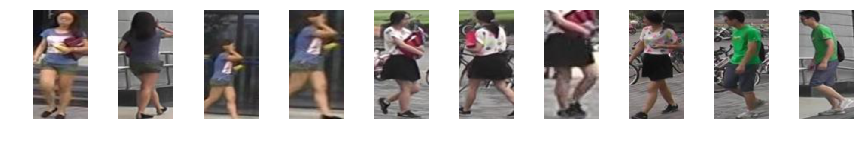

In [8]:
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_2_k'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

In [9]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0001):
    drop = 0.5
    epochs_drop = 5.0
    lrate = init_lr * np.power(drop,((epoch + init_epoch)/(epochs_drop)))
    return lrate
"""

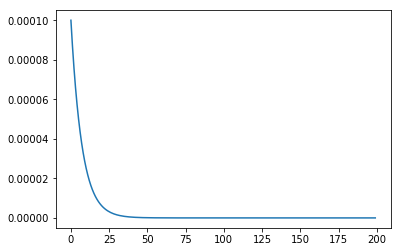

In [10]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [11]:
def plot_score(score):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    pos_distance = score['pos_distance']
    neg_distance = score['neg_distance']
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
    plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')

    plt.subplot(1,3,2)
    plt.plot(score['recall'], score['precision'])
    plt.xlabel('recall')
    plt.ylabel('precision')

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    
    plt.show()

    print score['rank']

#### Vanilla Front and Back

In [32]:
# https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
TF_ROOT = '/home/albert/github/tensorflow/'
base_model = load_model(TF_ROOT + \
                        'models/densenet_triplet_margin_preprocess/densenet_triplet_margin_preprocess_17000.h5',
                        custom_objects={'triplet_loss':triplet_merge.triplet_loss})
front_model = load_model(TF_ROOT + \
                         'models/densenet_triplet_front_vanilla/densenet_triplet_front_vanilla_12000.h5',
                         custom_objects={'triplet_loss':triplet_merge.triplet_loss})
back_model = load_model(TF_ROOT + \
                         'models/densenet_triplet_back_vanilla/densenet_triplet_back_vanilla_14000.h5',
                         custom_objects={'triplet_loss':triplet_merge.triplet_loss})

for layer in base_model.layers:
    layer.name = layer.name + '_b'
for layer in front_model.layers:
    layer.name = layer.name + '_f'
for layer in back_model.layers:
    layer.name = layer.name + '_k'

In [33]:
for layer in base_model.layers[:-2]:
    layer.trainable = False
for layer in front_model.layers[:-2]:
    layer.trainable = False
for layer in back_model.layers[:-2]:
    layer.trainable = False

In [34]:
x = concatenate([base_model.output, front_model.output, back_model.output])
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128, name='final_output')(x)

In [35]:
model = Model(inputs=[base_model.input, front_model.input, back_model.input], outputs=predictions)
model.compile(loss=triplet_merge.triplet_loss, 
              optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1_b (InputLayer)           (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_1_f (InputLayer)           (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_2_k (InputLayer)           (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1_b (Conv2D)              (None, 128, 64, 64)   9408        input_1_b[0][0]                  
___________________________________________________________________________________________

____________________________________________________________________________________________________
conv2d_90_b (Conv2D)             (None, 8, 4, 32)      36864       activation_90_b[0][0]            
____________________________________________________________________________________________________
conv2d_90_f (Conv2D)             (None, 8, 4, 32)      36864       activation_90_f[0][0]            
____________________________________________________________________________________________________
conv2d_210_k (Conv2D)            (None, 8, 4, 32)      36864       activation_212_k[0][0]           
____________________________________________________________________________________________________
concatenate_43_b (Concatenate)   (None, 8, 4, 544)     0           average_pooling2d_3_b[0][0]      
                                                                   conv2d_90_b[0][0]                
___________________________________________________________________________________________

In [37]:
for layer in model.layers[:-8]:
    layer.trainable = False

In [38]:
model.layers[-9].trainable

False

True
False
Epoch 1/10
100/100 [==============================] - 78s - loss: 22.7570    
Epoch 2/10
100/100 [==============================] - 76s - loss: 25.2988    
Epoch 3/10
100/100 [==============================] - 79s - loss: 17.5753    
Epoch 4/10
100/100 [==============================] - 79s - loss: 19.0024    
Epoch 5/10
100/100 [==============================] - 79s - loss: 13.5848    
Epoch 6/10
100/100 [==============================] - 79s - loss: 21.2341    
Epoch 7/10
100/100 [==============================] - 81s - loss: 15.0980    
Epoch 8/10
100/100 [==============================] - 79s - loss: 14.7658    
Epoch 9/10
100/100 [==============================] - 79s - loss: 16.9840    
Epoch 10/10
100/100 [==============================] - 79s - loss: 16.0549    
preprocess True
overlay False
train True
1000 65.2639560699
2000 125.773846149
3000 186.336692095
4000 246.81509614
5000 307.336086988
6000 367.836922169
7000 428.420150042
8000 488.964436054
9000 549.4503710

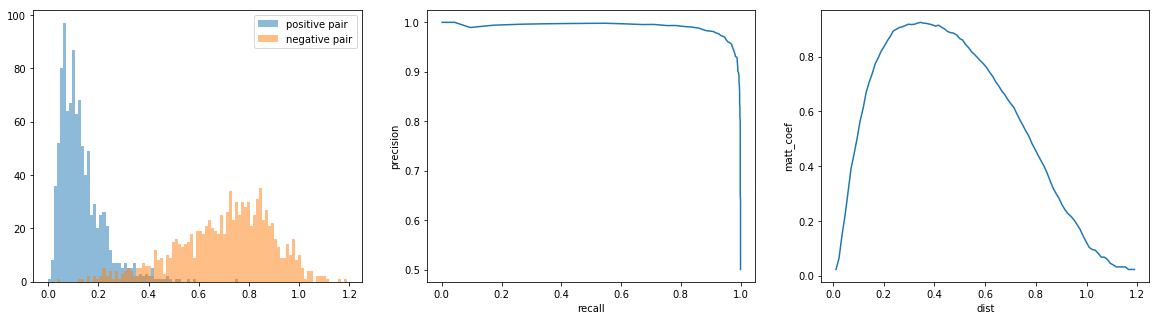

{1: 0.92133333333333345, 20: 0.996, 5: 0.97900000000000009}
preprocess True
overlay False
train False
1000 60.1413750648
2000 120.208468914
3000 180.273069859
4000 240.37901783
5000 300.505374908
6000 360.572953939
7000 420.643749952
8000 480.706418037
9000 540.757761955
10000 600.827149868
11000 660.910183907
12000 721.019448996
13000 781.085796833
test 1000


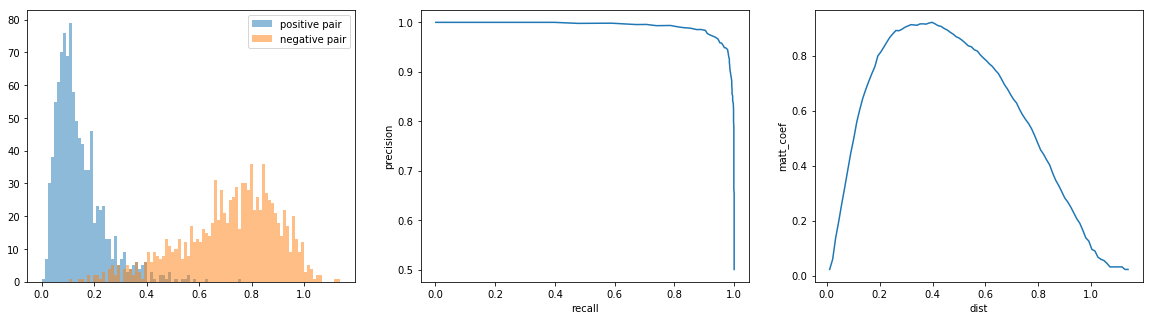

{1: 0.89566666666666672, 20: 0.9860000000000001, 5: 0.97000000000000008}
True
False
Epoch 1/10
100/100 [==============================] - 80s - loss: 14.8038    
Epoch 2/10
100/100 [==============================] - 77s - loss: 13.0897    
Epoch 3/10
100/100 [==============================] - 77s - loss: 19.1151    
Epoch 4/10
100/100 [==============================] - 79s - loss: 15.4464    
Epoch 5/10
100/100 [==============================] - 78s - loss: 9.9735     
Epoch 6/10
100/100 [==============================] - 77s - loss: 13.3492    
Epoch 7/10
100/100 [==============================] - 77s - loss: 12.6351    
Epoch 8/10
100/100 [==============================] - 80s - loss: 12.3310    
Epoch 9/10
100/100 [==============================] - 77s - loss: 12.8592    
Epoch 10/10
100/100 [==============================] - 78s - loss: 10.2558    
preprocess True
overlay False
train True
1000 60.0543019772
2000 120.047107935
3000 180.057734013
4000 240.008724928
5000 300.0298419
6

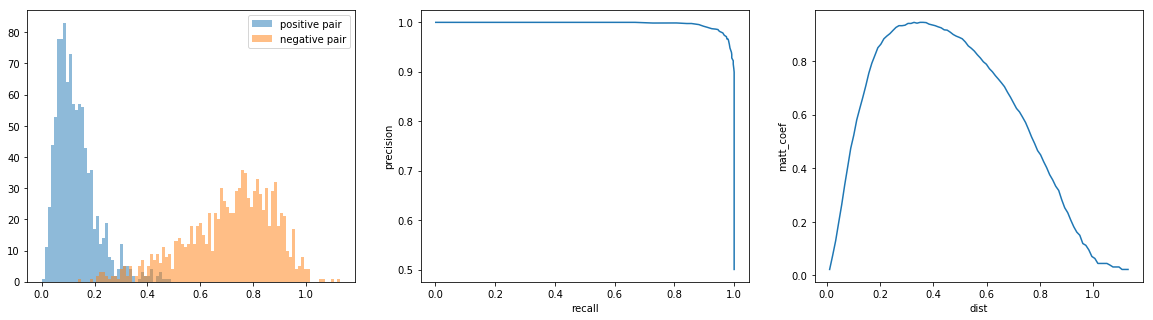

{1: 0.93066666666666675, 20: 0.9946666666666667, 5: 0.97999999999999998}
preprocess True
overlay False
train False
1000 59.9268229008
2000 119.917350054
3000 179.868052959
4000 239.957182884
5000 299.926583052
6000 359.945335865
7000 419.905405998
8000 479.980211973
9000 539.965162992
10000 600.041517973
11000 660.039886951
12000 720.103541851
13000 780.158602953
test 2000


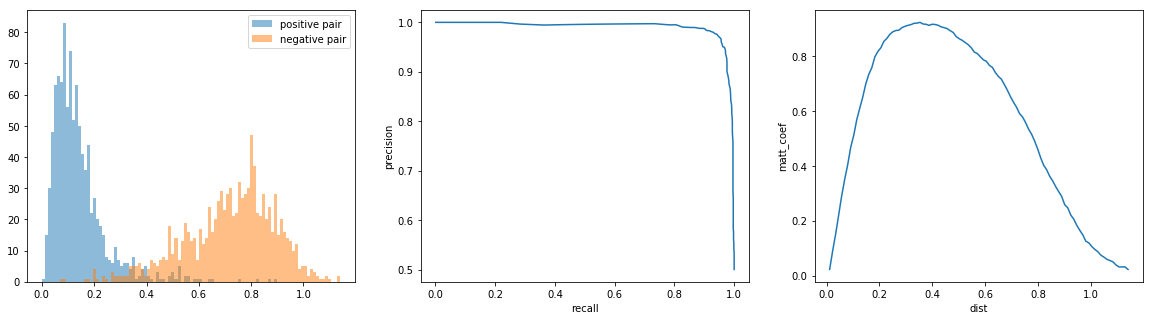

{1: 0.90366666666666673, 20: 0.9860000000000001, 5: 0.96599999999999986}
True
False
Epoch 1/10
100/100 [==============================] - 81s - loss: 10.0709    
Epoch 2/10
100/100 [==============================] - 77s - loss: 9.4807    
Epoch 3/10
100/100 [==============================] - 78s - loss: 12.2505    
Epoch 4/10
100/100 [==============================] - 77s - loss: 7.4309    
Epoch 5/10
100/100 [==============================] - 80s - loss: 10.3772    
Epoch 6/10
100/100 [==============================] - 78s - loss: 10.4915    
Epoch 7/10
100/100 [==============================] - 77s - loss: 13.0701    
Epoch 8/10
100/100 [==============================] - 78s - loss: 13.4934    
Epoch 9/10
100/100 [==============================] - 80s - loss: 16.2679    
Epoch 10/10
100/100 [==============================] - 78s - loss: 12.8436    
preprocess True
overlay False
train True
1000 59.9912569523
2000 119.942482948
3000 179.872367859
4000 239.816048861
5000 299.786741972
6

/home/albert/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/albert/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train 3000


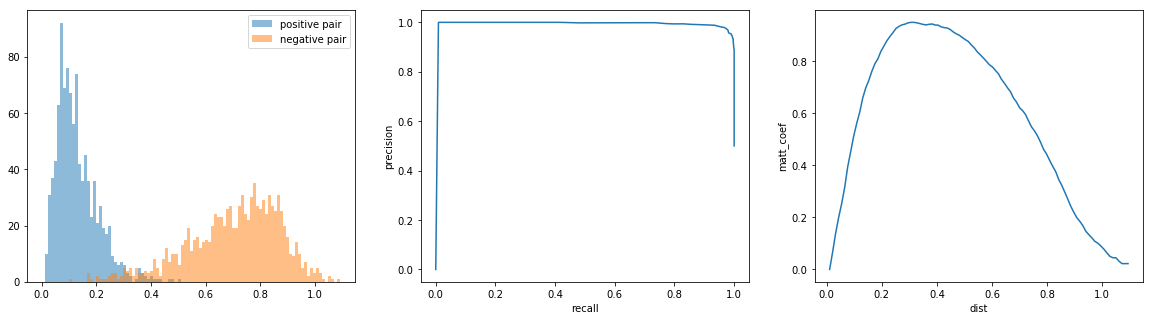

{1: 0.93300000000000016, 20: 0.99533333333333329, 5: 0.98233333333333339}
preprocess True
overlay False
train False
1000 60.0127029419
2000 120.050081015
3000 180.090260983
4000 240.047381878
5000 300.066601992
6000 360.039851904
7000 420.053035975
8000 480.073068857
9000 540.136621952
10000 600.110752821
11000 660.125452995
12000 720.167848825
13000 780.208981991
test 3000


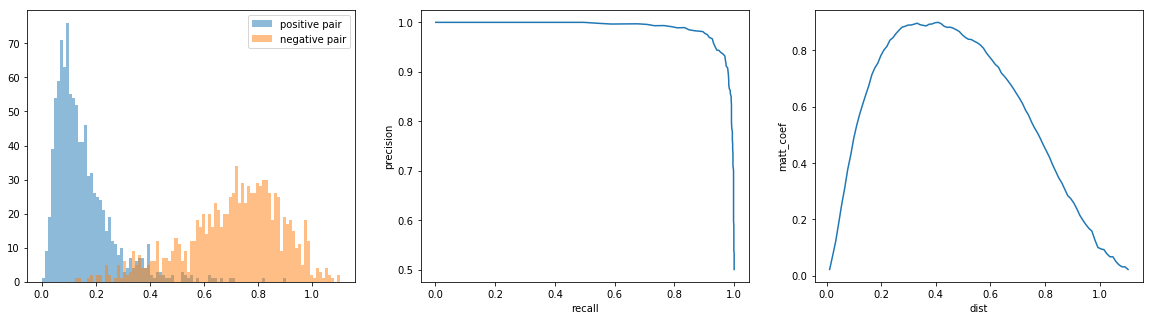

{1: 0.89966666666666661, 20: 0.98766666666666669, 5: 0.97699999999999998}
True
False
Epoch 1/10
100/100 [==============================] - 78s - loss: 7.4270    
Epoch 2/10
100/100 [==============================] - 80s - loss: 11.0131    
Epoch 3/10
100/100 [==============================] - 78s - loss: 11.5564    
Epoch 4/10
100/100 [==============================] - 77s - loss: 16.5494    
Epoch 5/10
100/100 [==============================] - 77s - loss: 10.3247    
Epoch 6/10
100/100 [==============================] - 79s - loss: 11.4078    
Epoch 7/10
100/100 [==============================] - 78s - loss: 11.4309    
Epoch 8/10
100/100 [==============================] - 77s - loss: 8.7656    
Epoch 9/10
100/100 [==============================] - 77s - loss: 8.9216    
Epoch 10/10
100/100 [==============================] - 79s - loss: 12.5803    
preprocess True
overlay False
train True
1000 59.8597950935
2000 119.888515949
3000 179.792855024
4000 239.746790886
5000 299.677051067
6

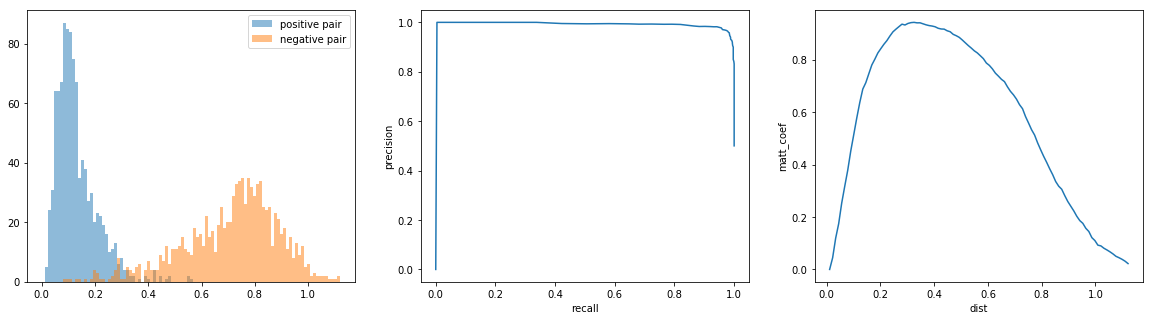

{1: 0.92266666666666675, 20: 0.9956666666666667, 5: 0.97733333333333328}
preprocess True
overlay False
train False
1000 59.9879751205
2000 119.961912155
3000 179.893256187
4000 239.788746119
5000 299.754220009
6000 359.680020094
7000 419.663319111
8000 479.623341084
9000 539.581099033
10000 599.533029079
11000 659.477181196
12000 719.421415091
13000 779.470038176
test 4000


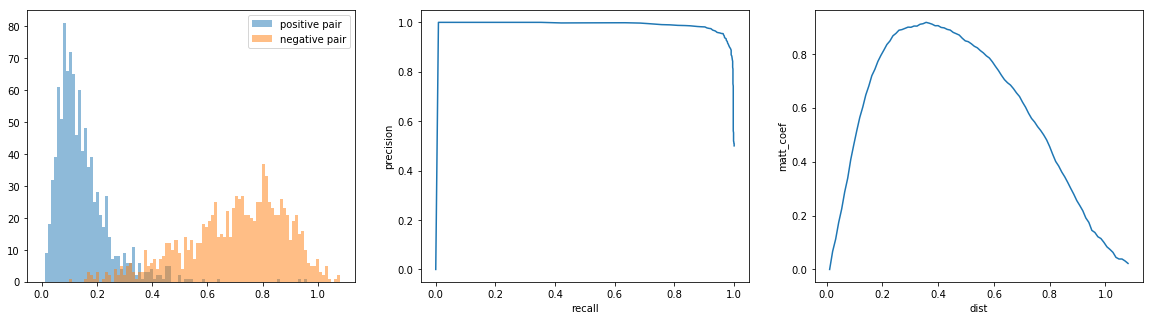

{1: 0.90800000000000003, 20: 0.98799999999999999, 5: 0.97366666666666679}


In [39]:
train_score = {}
test_score = {}
history = History()

for era in range(1,5):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    model.fit_generator(triplet_merge.output_batch_generator(train_dict, train_labels, 
                                                        overlay=overlay, preprocess=preprocess, 
                                                        shape=input_shape), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    model.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    
    train_score[iterations] = triplet_merge.get_score(model, train_dict, train_files, hist=history, 
                                        overlay=overlay_eval, train=True, preprocess=preprocess, 
                                               shape=input_shape)
    print 'train' , iterations
    plot_score(train_score[iterations])

    test_score[iterations] = triplet_merge.get_score(model, test_dict, test_files, hist=history, 
                                        overlay=overlay_eval, train=False, preprocess=preprocess, 
                                               shape=input_shape)
    print 'test', iterations
    plot_score(test_score[iterations])

In [40]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)

#### Keypoint Models

In [12]:
import triplet_merge_key

In [13]:
file_root = 'densenet_triplet_merge_5'

In [14]:
# https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
TF_ROOT = '/home/albert/github/tensorflow/'
base_model = load_model(TF_ROOT + \
                        'models/densenet_triplet_margin_preprocess/densenet_triplet_margin_preprocess_17000.h5',
                        custom_objects={'triplet_loss':triplet_merge.triplet_loss})
front_model = load_model(TF_ROOT + \
                         'models/densenet_triplet_front_256x128/densenet_triplet_front_256x128_14000.h5',
                         custom_objects={'triplet_loss':triplet_merge.triplet_loss})
back_model = load_model(TF_ROOT + \
                         'models/densenet_triplet_back_256x128/densenet_triplet_back_256x128_14000.h5',
                         custom_objects={'triplet_loss':triplet_merge.triplet_loss})

for layer in base_model.layers:
    layer.name = layer.name + '_b'
for layer in front_model.layers:
    layer.name = layer.name + '_f'
for layer in back_model.layers:
    layer.name = layer.name + '_k'

In [15]:
for layer in base_model.layers[:-2]:
    layer.trainable = False
for layer in front_model.layers[:-2]:
    layer.trainable = False
for layer in back_model.layers[:-2]:
    layer.trainable = False

In [16]:
x = concatenate([base_model.output, front_model.output, back_model.output])
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128, name='final_output')(x)

In [17]:
model = Model(inputs=[base_model.input, front_model.input, back_model.input], outputs=predictions)
model.compile(loss=triplet_merge_key.triplet_loss, 
              optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [18]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1_b (InputLayer)           (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_1_f (InputLayer)           (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_1_k (InputLayer)           (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1_b (Conv2D)              (None, 128, 64, 64)   9408        input_1_b[0][0]                  
___________________________________________________________________________________________

____________________________________________________________________________________________________
batch_normalization_91_f (BatchN (None, 8, 4, 544)     2176        concatenate_43_f[0][0]           
____________________________________________________________________________________________________
batch_normalization_91_k (BatchN (None, 8, 4, 544)     2176        concatenate_43_k[0][0]           
____________________________________________________________________________________________________
activation_91_b (Activation)     (None, 8, 4, 544)     0           batch_normalization_91_b[0][0]   
____________________________________________________________________________________________________
activation_91_f (Activation)     (None, 8, 4, 544)     0           batch_normalization_91_f[0][0]   
____________________________________________________________________________________________________
activation_91_k (Activation)     (None, 8, 4, 544)     0           batch_normalization_91_k

In [19]:
for layer in model.layers[:-8]:
    layer.trainable = False

True
False
Epoch 1/10
100/100 [==============================] - 86s - loss: 29.7267    
Epoch 2/10
100/100 [==============================] - 82s - loss: 21.4410    
Epoch 3/10
100/100 [==============================] - 82s - loss: 23.0624    
Epoch 4/10
100/100 [==============================] - 84s - loss: 16.9515    
Epoch 5/10
100/100 [==============================] - 82s - loss: 16.4674    
Epoch 6/10
100/100 [==============================] - 84s - loss: 16.6231    
Epoch 7/10
100/100 [==============================] - 82s - loss: 16.8553    
Epoch 8/10
100/100 [==============================] - 81s - loss: 19.7251    
Epoch 9/10
100/100 [==============================] - 81s - loss: 13.8675    
Epoch 10/10
100/100 [==============================] - 81s - loss: 11.8171    
preprocess True
overlay False
train True
1000 62.6905620098
2000 121.990456104
3000 181.70206213
4000 242.544137001
5000 302.501005173
6000 361.869965076
7000 421.561629057
8000 481.232143164
9000 540.5496001

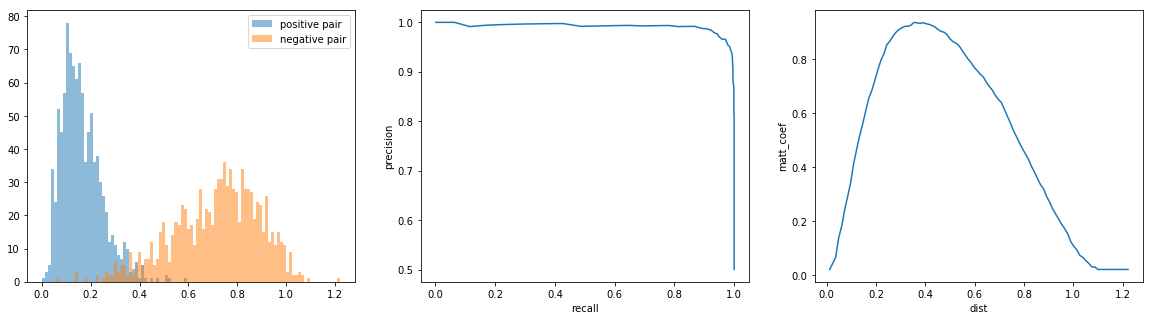

{1: 0.90600000000000003, 20: 0.99299999999999999, 5: 0.96899999999999997}
preprocess True
overlay False
train False
1000 58.2461969852
2000 116.530421019
3000 174.7636621
4000 233.033060074
5000 291.542380095
6000 349.893033028
7000 408.187138081
8000 466.413099051
9000 524.711947918
10000 583.113932133
11000 641.391535997
12000 699.662786961
13000 757.965626955


/home/albert/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/albert/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


test 1000


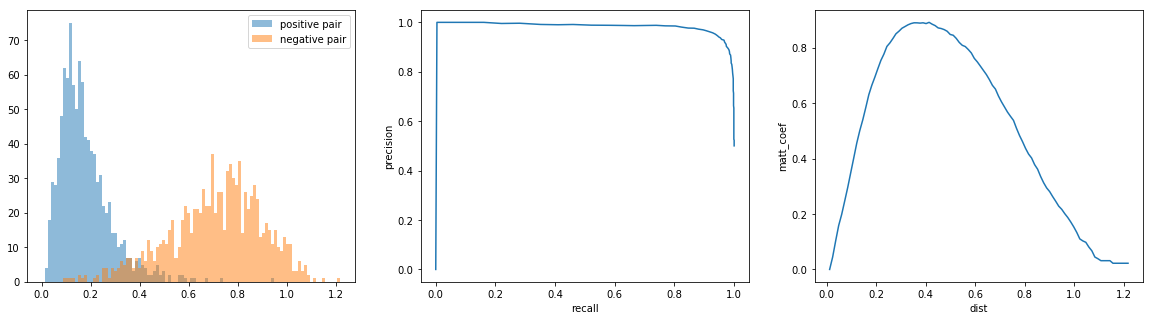

{1: 0.879, 20: 0.98933333333333329, 5: 0.95999999999999996}
True
False
Epoch 1/10
100/100 [==============================] - 79s - loss: 18.0777    
Epoch 2/10
100/100 [==============================] - 78s - loss: 15.4275    
Epoch 3/10
100/100 [==============================] - 79s - loss: 17.0218    
Epoch 4/10
100/100 [==============================] - 78s - loss: 13.1389    
Epoch 5/10
100/100 [==============================] - 78s - loss: 18.3841    
Epoch 6/10
100/100 [==============================] - 77s - loss: 12.7902    
Epoch 7/10
100/100 [==============================] - 79s - loss: 13.5358    
Epoch 8/10
100/100 [==============================] - 79s - loss: 11.1492    
Epoch 9/10
100/100 [==============================] - 79s - loss: 10.4810    
Epoch 10/10
  1/100 [..............................] - ETA: 50s - loss: 35.1198

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.245569). Check your callbacks.
  % delta_t_median)


  2/100 [..............................] - ETA: 109s - loss: 22.7202

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.628806). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 79s - loss: 11.2065    
preprocess True
overlay False
train True
1000 58.227889061
2000 116.433604956
3000 174.600723028
4000 232.804522038
5000 290.970468998
6000 349.173307896
7000 407.310724974
8000 465.492348909
9000 523.719199896
10000 581.895323992
11000 640.076694965
12000 698.22734499
train 2000


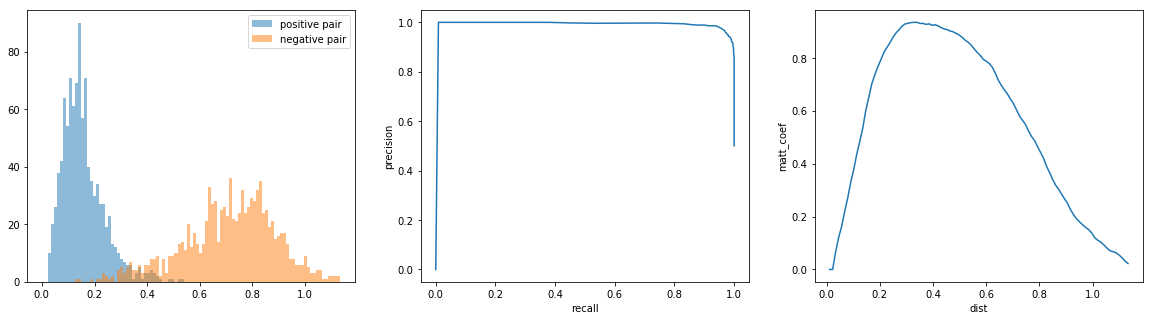

{1: 0.91300000000000014, 20: 0.9943333333333334, 5: 0.98333333333333339}
preprocess True
overlay False
train False
1000 59.3761899471
2000 118.879728079
3000 177.314724922
4000 235.573810101
5000 293.824054003
6000 352.047132969
7000 410.560657024
8000 468.786056042
9000 527.065203905
10000 585.294143915
11000 643.606779099
12000 702.118096113
13000 760.41919899
test 2000


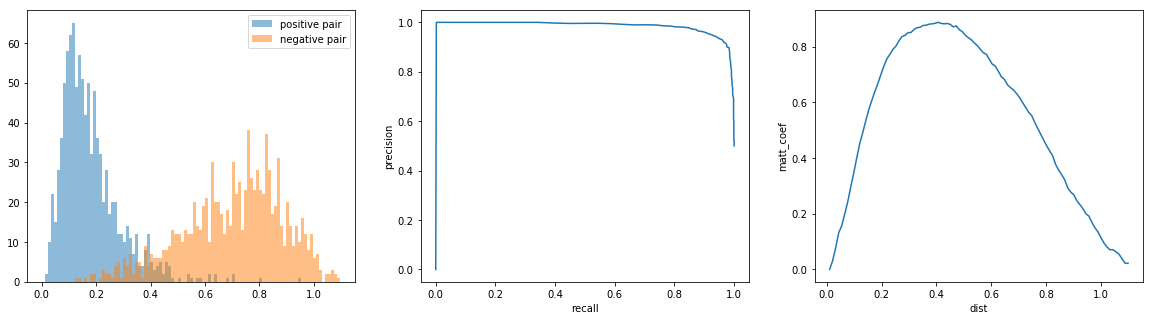

{1: 0.88100000000000012, 20: 0.98866666666666669, 5: 0.96466666666666667}
True
False
Epoch 1/10
100/100 [==============================] - 79s - loss: 18.3327    
Epoch 2/10
100/100 [==============================] - 78s - loss: 13.5663    
Epoch 3/10
100/100 [==============================] - 78s - loss: 12.9102    
Epoch 4/10
100/100 [==============================] - 78s - loss: 11.6970    
Epoch 5/10
100/100 [==============================] - 78s - loss: 17.2947    
Epoch 6/10
100/100 [==============================] - 77s - loss: 12.1837    
Epoch 7/10
100/100 [==============================] - 78s - loss: 12.9632    
Epoch 8/10
100/100 [==============================] - 78s - loss: 14.1753    
Epoch 9/10
100/100 [==============================] - 78s - loss: 9.3219    
Epoch 10/10
100/100 [==============================] - 78s - loss: 10.8246    
preprocess True
overlay False
train True
1000 58.9746489525
2000 117.616956949
3000 175.900427103
4000 235.116281986
5000 294.639219999

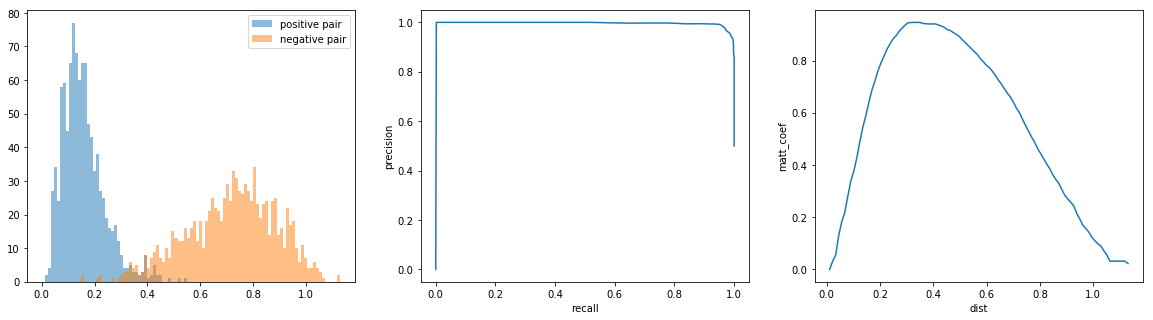

{1: 0.91533333333333333, 20: 0.9943333333333334, 5: 0.97733333333333328}
preprocess True
overlay False
train False
1000 58.3408191204
2000 116.569458961
3000 174.819767952
4000 233.035018921
5000 291.202980042
6000 349.878457069
7000 408.017946959
8000 466.170223951
9000 524.318700075
10000 582.559592962
11000 640.75594902
12000 699.057821989
13000 757.280961037
test 3000


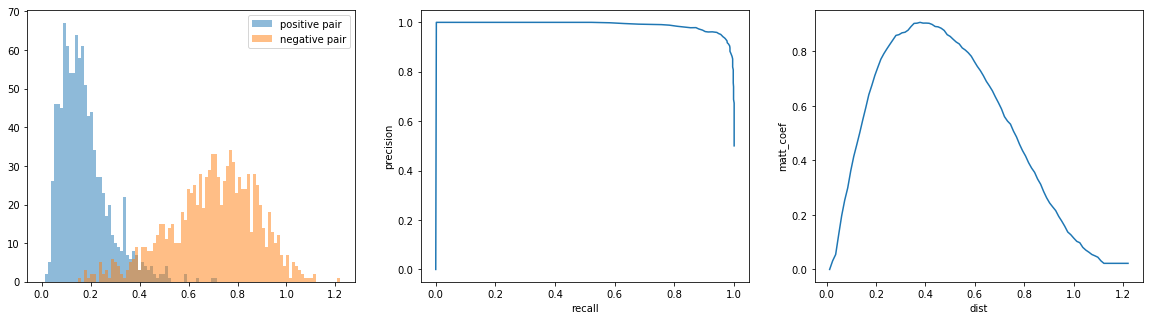

{1: 0.88733333333333331, 20: 0.98566666666666658, 5: 0.95766666666666656}
True
False
Epoch 1/10
100/100 [==============================] - 79s - loss: 8.5717    
Epoch 2/10
100/100 [==============================] - 78s - loss: 9.5377    
Epoch 3/10
100/100 [==============================] - 78s - loss: 8.7787    
Epoch 4/10
100/100 [==============================] - 78s - loss: 11.5750    
Epoch 5/10
100/100 [==============================] - 78s - loss: 15.5035    
Epoch 6/10
100/100 [==============================] - 77s - loss: 13.7349    
Epoch 7/10
100/100 [==============================] - 78s - loss: 14.3250    
Epoch 8/10
100/100 [==============================] - 78s - loss: 15.5378    
Epoch 9/10
100/100 [==============================] - 78s - loss: 12.7842    
Epoch 10/10
100/100 [==============================] - 78s - loss: 11.5675    
preprocess True
overlay False
train True
1000 58.254103899
2000 116.533741951
3000 174.851055861
4000 233.190136909
5000 291.441911936
60

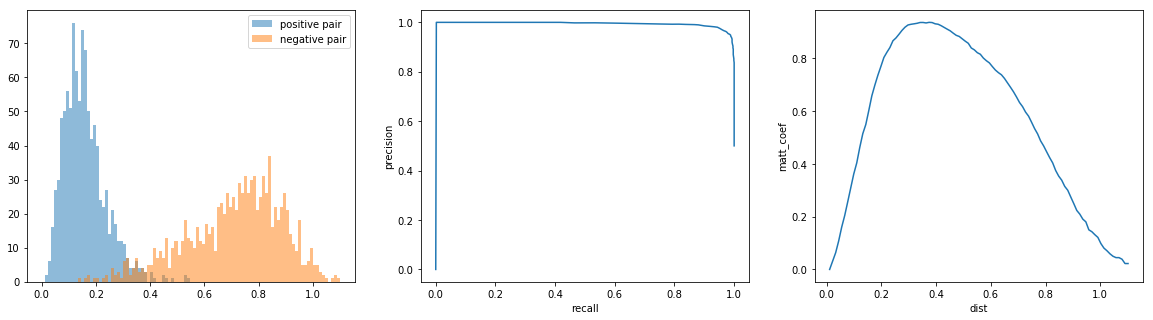

{1: 0.90766666666666662, 20: 0.99099999999999999, 5: 0.98066666666666669}
preprocess True
overlay False
train False
1000 58.1337890625
2000 116.319468975
3000 174.46729207
4000 232.687439919
5000 290.809490919
6000 348.975020885
7000 407.648746967
8000 465.861471891
9000 524.030740023
10000 582.186289072
11000 640.350293875
12000 698.55330205
13000 756.701718092
test 4000


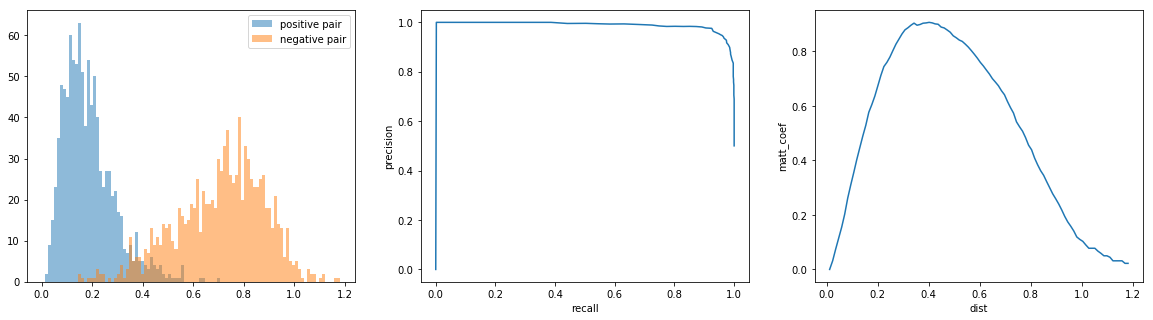

{1: 0.88533333333333342, 20: 0.98799999999999999, 5: 0.96566666666666656}


In [20]:
train_score = {}
test_score = {}
history = History()

for era in range(1,5):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    model.fit_generator(triplet_merge_key.output_batch_generator(train_dict, train_labels, 
                                                        overlay=overlay, preprocess=preprocess, 
                                                        shape=input_shape), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    model.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    
    train_score[iterations] = triplet_merge_key.get_score(model, train_dict, train_files, hist=history, 
                                        overlay=overlay_eval, train=True, preprocess=preprocess, 
                                               shape=input_shape)
    print 'train' , iterations
    plot_score(train_score[iterations])

    test_score[iterations] = triplet_merge_key.get_score(model, test_dict, test_files, hist=history, 
                                        overlay=overlay_eval, train=False, preprocess=preprocess, 
                                               shape=input_shape)
    print 'test', iterations
    plot_score(test_score[iterations])

In [21]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)

### Evaluation

In [20]:
model.save('test.h5')

In [12]:
model = load_model('test.h5', custom_objects={'triplet_loss' : triplet_merge.triplet_loss})

preprocess True
overlay False
train True
1000 60.5339078903
2000 119.347881794
3000 177.394331932
4000 235.978888988
5000 294.12349391
6000 352.212751865
7000 410.492074966
8000 468.870644808
9000 526.828066826
10000 584.858431816
11000 642.880310774
12000 700.904673815
train


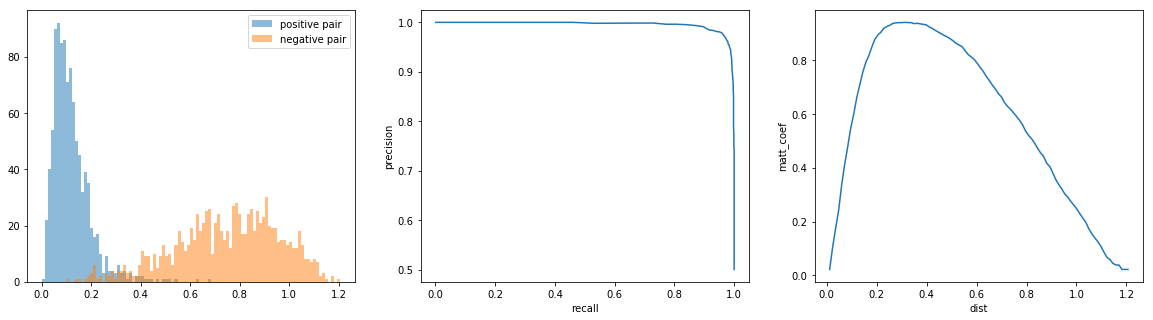

{1: 0.92766666666666675, 20: 0.9946666666666667, 5: 0.98266666666666669}
preprocess True
overlay False
train False
1000 58.5906598568
2000 117.229493856
3000 175.739275932
4000 234.214504957
5000 293.097357988
6000 351.749939919
7000 410.792378902
8000 470.220442057
9000 528.669713974
10000 587.012306929
11000 645.615017891
12000 704.095888853
13000 762.806591034
test


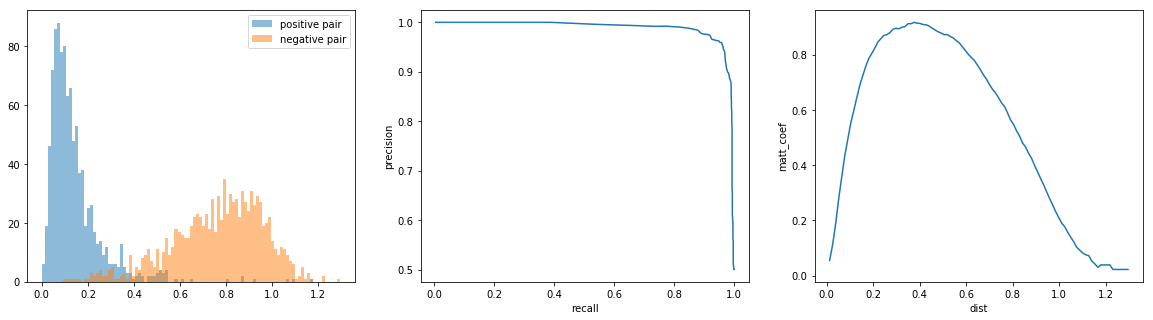

{1: 0.90466666666666662, 20: 0.98933333333333329, 5: 0.96933333333333327}


In [14]:
train_score = triplet_merge.get_score(model, train_dict, train_files, hist=None, 
                                        overlay=overlay_eval, train=True, preprocess=preprocess, 
                                           shape=input_shape)
print 'train'
plot_score(train_score)

test_score = triplet_merge.get_score(model, test_dict, test_files, hist=None, 
                                    overlay=overlay_eval, train=False, preprocess=preprocess, 
                                           shape=input_shape)
print 'test'
plot_score(test_score)

In [16]:
file_root = 'densenet_triplet_merge_1000'
np.savez('/home/albert/github/tensorflow/models/%s_score.npz' % (file_root), train_score)
np.savez('/home/albert/github/tensorflow/models/%s_test_score.npz' % (file_root), test_score)